**2D nonlinear diffusion-reaction system**

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from torch.utils.data import TensorDataset, DataLoader

In [22]:
num_samples = 100

# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.cos(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=0.5):
    u = exact_solution(x, y)
    f = lambd * (torch.pi**2 * (torch.sin(torch.pi * x) * torch.cos(torch.pi * y) + torch.cos(torch.pi * x) * torch.sin(torch.pi * y))) + k * u**2
    return f

In [23]:
def sample_dataset_nonlinear(noise_scale=0.01, num_samples=100, device='cpu', lambd=0.01, k=0.5):
    x = torch.linspace(-1, 1, num_samples, device=device) # Space domain for x
    y = torch.linspace(-1, 1, num_samples, device=device) # Space domain for y

    X, Y = torch.meshgrid(x, y, indexing='ij') # 2D Space domain

    # Generate the true solution and source term
    u_true = exact_solution(X, Y)
    f_true = source_term(X, Y, lambd, k)

    # Flatten X, Y, u_true and f_true
    X_flat = X.reshape(-1, 1)
    Y_flat = Y.reshape(-1, 1)
    u_true_flat = u_true.reshape(-1, 1)
    f_true_flat = f_true.reshape(-1, 1)

    # Add Gaussian noise to the true solution and source term
    u_noisy = u_true_flat + noise_scale * torch.randn_like(u_true_flat)
    f_noisy = f_true_flat + noise_scale * torch.randn_like(f_true_flat)

    return X_flat, Y_flat, u_noisy, f_noisy


def generate_sensor_locations(num_sensors=100, domain=[-1, 1], seed=0):
    np.random.seed(seed)
    sensor_coords = np.random.uniform(low=domain[0], high=domain[1], size=(num_sensors, 2))
    return torch.tensor(sensor_coords, dtype=torch.float32)


def create_train_test_datasets_nonlinear(num_sensors=100, num_boundary_sensors=25, noise_scale=0.01, device='cpu', batch_size=32, lambd=0.01, k=0.5):
    # Generate sensor locations for u and f
    sensor_locations = generate_sensor_locations(num_sensors=num_sensors)
    x_sensors = sensor_locations[:, 0].unsqueeze(1)
    y_sensors = sensor_locations[:, 1].unsqueeze(1)
    
    # Generate measurements at sensor locations
    x_sensors, y_sensors, u_noisy_sensors, f_noisy_sensors = sample_dataset_nonlinear(noise_scale=noise_scale, num_samples=num_samples, device=device, lambd=lambd, k=k)
    
    # Create boundary sensors for u (assuming they are equally spaced)
    x_boundary = torch.linspace(-1, 1, num_boundary_sensors, device=device, dtype=torch.float32)
    y_boundary = torch.tensor([-1, 1], device=device, dtype=torch.float32).repeat_interleave(num_boundary_sensors // 2)

    # match datatypes 
    X_boundary, Y_boundary = torch.meshgrid(x_boundary, y_boundary)
    u_boundary_true = exact_solution(X_boundary, Y_boundary).reshape(-1, 1)

    # adding noise
    u_boundary_noisy = u_boundary_true + noise_scale * torch.randn_like(u_boundary_true)

    # create train dataset
    train_dataset = TensorDataset(x_sensors, y_sensors, u_noisy_sensors, f_noisy_sensors)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    boundary_dataset = TensorDataset(X_boundary.reshape(-1, 1), Y_boundary.reshape(-1, 1), u_boundary_noisy)
    boundary_loader = DataLoader(boundary_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, boundary_loader

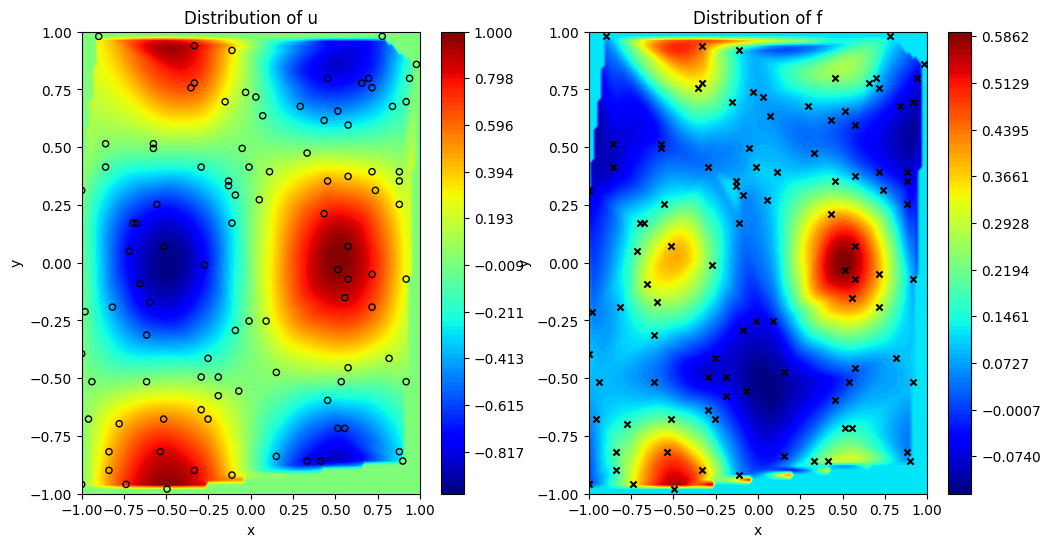

In [24]:
# Configure the noise scales for the measurements
noise_scale_f = 0.01 # Noise scale for f
noise_scale_u = 0.01 # Noise scale for u
noise_scale_b = 0.01 # Noise scale for boundary conditions

# Create data loaders
train_loader, boundary_loader = create_train_test_datasets_nonlinear(
    num_sensors=100,
    num_boundary_sensors=25,
    noise_scale=noise_scale_u,
    device='cpu',
    batch_size=num_samples,
    lambd=0.01,
    k=0.5
)

# Extract data from loaders for visualization
# Since there are no actual labels, just features, we don't unpack train_labels
for train_features in train_loader:
    x_sensors, y_sensors, u_noisy_sensors, f_noisy_sensors = train_features
    break  # Just to get the first batch

for boundary_features in boundary_loader:
    X_boundary, Y_boundary, u_boundary_noisy = boundary_features
    break  # Just to get the first batch

# Prepare the grid to interpolate the data on
grid_x, grid_y = np.mgrid[-1:1:100j, -1:1:100j]


u_interp = griddata((x_sensors.numpy().squeeze(), y_sensors.numpy().squeeze()), 
                    u_noisy_sensors.numpy().squeeze(), (grid_x, grid_y), method='cubic')
f_interp = griddata((x_sensors.numpy().squeeze(), y_sensors.numpy().squeeze()), 
                    f_noisy_sensors.numpy().squeeze(), (grid_x, grid_y), method='cubic')

# Ensure that NaN values are handled. If the cubic interpolation works well, you may not need this step.
u_interp = np.nan_to_num(u_interp, nan=np.nanmean(u_interp))
f_interp = np.nan_to_num(f_interp, nan=np.nanmean(f_interp))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Adjust the levels of the contour to use fixed levels that match the range of your data
u_levels = np.linspace(u_interp.min(), u_interp.max(), 100)
f_levels = np.linspace(f_interp.min(), f_interp.max(), 100)

# Distribution of u
u_contour = ax[0].contourf(grid_x, grid_y, u_interp, cmap='jet', levels=u_levels)
ax[0].scatter(x_sensors.numpy(), y_sensors.numpy(), facecolors='none', edgecolors='black', s=20, marker='o')  
ax[0].set_title('Distribution of u')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
plt.colorbar(u_contour, ax=ax[0])

# Distribution of f
f_contour = ax[1].contourf(grid_x, grid_y, f_interp, cmap='jet', levels=f_levels)
ax[1].scatter(x_sensors.numpy(), y_sensors.numpy(), c='black', s=20, marker='x') 
ax[1].set_title('Distribution of f')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
plt.colorbar(f_contour, ax=ax[1])

plt.show()